<a href="https://colab.research.google.com/github/namwootree/Basic_Skill/blob/main/Time_Series/%EC%8B%9C%EA%B3%84%EC%97%B4_%EB%B6%84%EC%84%9D_%EC%84%B8%EB%AF%B8%EB%82%98_%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 시계열 분석 세미나 개념 설명

[Velog Link](https://velog.io/@namwootree/%EC%8B%9C%EA%B3%84%EC%97%B4-%EB%B6%84%EC%84%9D-%EC%84%B8%EB%AF%B8%EB%82%98-1-%EA%B0%9C%EB%85%90-%EC%84%A4%EB%AA%85)

# Setting

In [64]:
!nvidia-smi

Thu Jul 28 08:00:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 라이브러리 불러오기

In [65]:
import warnings
warnings.filterwarnings("ignore")

In [66]:
# 기본
import itertools # 자신만의 반복자를 만드는 모듈
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import rcParams
import joblib # 디스크 캐싱, 병렬 프로그래밍, 학습한 모델을 저장
from sklearn.metrics import make_scorer

In [67]:
!pip install pystan==2.19.1.1
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [68]:
# 시계열
import prophet
from datetime import datetime as dt
from statsmodels.tsa.arima_model import ARIMA
from dateutil.relativedelta import relativedelta # 날짜 계산
import statsmodels.tsa.api as tsa
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import statsmodels
import statsmodels.api as sm  
import statsmodels.graphics.tsaplots as sgt

In [69]:
# 회귀분석
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

In [70]:
# Deep Neural Network
from tensorflow.keras import layers, models
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential
import time

In [71]:
# 설정
%matplotlib inline
pd.options.display.max_columns = 400
pd.options.display.float_format = '{:.5f}'.format
from tqdm.notebook import tqdm
import random

## 예측 오차 설정하기

In [72]:
def mae(prediction, correct):

  prediction = np.array(prediction)
  correct = np.array(correct)

  difference = correct - prediction
  abs_val = abs(difference)

  score = abs_val.mean()

  return score

mae_score = make_scorer(mae)
mae_score

make_scorer(mae)

## 모델 시각화

In [73]:
def plot_model_graph(data_frame, store_num, idx_col, y_cols):
    df_set = data_frame[data_frame.store_id == store_num]
    
    fig, ax1 = plt.subplots(figsize=(10, 3))
    ax1.set_xlabel("{}".format(idx_col))
    ax1.set_ylabel("{}".format(y_cols[0])).set_color(color='tab:blue')
    ax1.plot(df_set.index, df_set[y_cols[0]].values, color='tab:blue')
    
    for i in range(1, len(y_cols)):
        ax2 = ax1.twinx()
        ax2.set_ylabel("{}".format(y_cols[i])).set_color(color='C{}'.format(i))
        ax2.plot(df_set.index, df_set[y_cols[i]].values, color='C{}'.format(i))
        ax2.spines['right'].set_position(('outward', (60*(i-1))))
        

    fig.tight_layout()
    plt.show()

In [74]:
def plot_train_test_pred_graph(trainset, testset, pred):
    plt.figure(figsize=(15,3))
    plt.plot(trainset.amount, label='train')
    plt.plot(testset.amount, label='test')
    plt.plot(testset.index, pred, label='prediction')
    plt.legend()
    plt.show()

## 데이터 불러오기

In [75]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
train_path = '/content/drive/MyDrive/시계열/상점 신용카드 매출 예측 경진대회/funda_train.csv' 
sub_path = '/content/drive/MyDrive/시계열/상점 신용카드 매출 예측 경진대회/submission.csv'

df_train = pd.read_csv(train_path)
df_sub = pd.read_csv(sub_path)

# 데이터 확인하기

In [77]:
df_train.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.14286
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.14286
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.00000
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.14286
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.00000


In [78]:
df_train.shape

(6556613, 9)

In [79]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6556613 entries, 0 to 6556612
Data columns (total 9 columns):
 #   Column            Dtype  
---  ------            -----  
 0   store_id          int64  
 1   card_id           int64  
 2   card_company      object 
 3   transacted_date   object 
 4   transacted_time   object 
 5   installment_term  int64  
 6   region            object 
 7   type_of_business  object 
 8   amount            float64
dtypes: float64(1), int64(3), object(5)
memory usage: 450.2+ MB


In [80]:
frame_info = [(col, # 각각의 Column
               len(df_train[col].unique()), # 고유값 개수
               df_train[col].isnull().sum(), # Null 개수
               df_train[col].dtype, # type
               df_train[col].unique()[:5]) # 앞에서 부터의 5개 샘플을 확인
               for col in df_train.columns]

df_info = pd.DataFrame(frame_info,
                       columns=['name', 'num_of_unique',
                                'num_of_nan', 'type',
                                'front5_values'])

# 데이터 전처리

## 시계열 분석을 위해 date를 index로 변환

In [81]:
df_train = df_train.set_index('transacted_date')

In [82]:
df_train.head()

,store_id,card_id,card_company,transacted_time,installment_term,region,type_of_business,amount
transacted_date,,,,,,,,
2016-06-01,0,0,b,13:13,0,NaN,기타 미용업,1857.14286
2016-06-01,0,1,h,18:12,0,NaN,기타 미용업,857.14286
2016-06-01,0,2,c,18:52,0,NaN,기타 미용업,2000.00000
2016-06-01,0,3,a,20:22,0,NaN,기타 미용업,7857.14286
2016-06-02,0,4,c,11:06,0,NaN,기타 미용업,2000.00000


## 새로운 Columns 생성

In [83]:
def preprocessing_day(DataFrame):
  
  # 새로운 데이터 프레임 생성
  new_df = pd.DataFrame()


  for store in tqdm(DataFrame.store_id.unique()):

    # 데이터 셋에서 상점의 고유 아이디 별 데이터 추출
    unique_store = DataFrame[DataFrame.store_id == store]
    unique_store.index = pd.to_datetime(unique_store.index)

    # '일 (day)'별로 사용한 카드의 고유 아이디별로 거래 횟수 확인
    count_cols = unique_store['card_id'].resample(rule='d').count().rename('num_of_pay')


    # 단골 방문 횟수, 'card_id'의 value 중 count가 2보다 큰(3 이상) value의 결제 건수
    count_visit = unique_store.card_id.value_counts().reset_index()

    cond_visit = (count_visit['card_id'] > 2)
    
    revisit_idx = count_visit.loc[cond_visit]["index"].values

    df_revisit = unique_store[unique_store.card_id.isin(revisit_idx)]
    df_revisit.index = pd.to_datetime(df_revisit.index)

    revisit_ct = df_revisit[df_revisit.card_id.isin(revisit_idx)].card_id.resample(rule='d').count().rename('num_of_revisit')

    # 할부 개월수와 매출액은 일 단위로 합
    sum_cols = unique_store[['installment_term', 'amount']].resample(rule='d').sum()

    # 새로운 Columns 병합
    preprocessing_df = pd.concat([count_cols, revisit_ct, sum_cols], axis=1)

    # 기존 Columns 불러오기
    preprocessing_df.insert(0, 'store_id', store)
    preprocessing_df.insert(4, 'region', unique_store[unique_store.store_id == store].region.unique()[0])
    preprocessing_df.insert(5, 'type_of_business', unique_store[unique_store.store_id == store].type_of_business.unique()[0])

    # 모두 병합
    new_df = pd.concat([new_df, preprocessing_df], axis=0)

  # 각 요일을 나타내는 숫자, 월요일은 0 일요일은 6
  new_df.insert(1, 'day_of_week', new_df.index.dayofweek)

  # working day 여부, 1이면 working day 0이면 주말
  new_df.insert(2, 'business_day', new_df.day_of_week.replace({0:1, 2:1, 3:1, 4:1, 5:0, 6:0}).values)

  # 단골 방문이 없는 경우 0으로 대체
  new_df.num_of_revisit.fillna(0, inplace=True)

  return new_df

In [84]:
day_df = preprocessing_day(df_train)

  0%|          | 0/1967 [00:00<?, ?it/s]

In [85]:
day_df.head()

,store_id,day_of_week,business_day,num_of_pay,num_of_revisit,installment_term,region,type_of_business,amount
transacted_date,,,,,,,,,
2016-06-01,0,2,1,4,4.00000,0,NaN,기타 미용업,12571.42857
2016-06-02,0,3,1,7,3.00000,0,NaN,기타 미용업,40571.42857
2016-06-03,0,4,1,3,2.00000,0,NaN,기타 미용업,18142.85714
2016-06-04,0,5,0,7,3.00000,0,NaN,기타 미용업,31714.28571
2016-06-05,0,6,0,3,3.00000,0,NaN,기타 미용업,10428.57143


In [86]:
day_df.isnull().sum()

store_id                  0
day_of_week               0
business_day              0
num_of_pay                0
num_of_revisit            0
installment_term          0
region               629927
type_of_business    1087791
amount                    0
dtype: int64

## Modeling을 위해 Month 단위로 변환

In [87]:
def preprocessing_month(day_df):
    sum_cols = ['num_of_pay', 'num_of_revisit', 'installment_term', 'amount']

    df_monthly = pd.DataFrame()

    for store in tqdm(day_df.store_id.unique()):
        df_set = day_df[day_df.store_id == store]
        
        # nan값이 발생하는 경우를 없애기 위해 이전, 이후 달에 대한 정보를 추가한 후 제거
        # date_range 함수를 이용하면 start와 end 날짜 사이의 모든 날짜를 담은 변수를 생성할 수 있음
        # concat 함수로 이전 이후 한 달 row를 추가로 붙임
        prev_date = pd.date_range(start=(df_set.index[0] - relativedelta(months=1)),
                                  end=(df_set.index[0] - relativedelta(months=1)))
        
        add_date = pd.date_range(start=(df_set.index[-1] + relativedelta(months=1)),
                                 end=(df_set.index[-1] + relativedelta(months=1)))
        
        df_set = pd.concat([pd.DataFrame(index=prev_date),
                            df_set,
                            pd.DataFrame(index=add_date)],
                            axis=0)
        
        # strftime 함수는 datetime 형식의 모양을 변경해주는 것 (연-월 단위)
        # 첫 달과 마지막 달에 1을 넣어둠
        df_set.loc[dt.strftime(df_set.index[0], '%Y-%m'), :] = 1
        df_set.loc[dt.strftime(df_set.index[-1], '%Y-%m'), :] = 1

        # 매출액이 0이 아닌 데이터에 대해 요일 카운트와 business day합을 넣음
        tot_day = df_set[df_set.amount != 0].day_of_week.resample(rule='m').count().rename('real_tot_day')
        business = df_set[df_set.amount != 0].business_day.resample(rule='m').sum().rename('real_business_day')

        # 이전 이후 달 삭제(drop 함수 이용해 인덱스 기준으로 삭제)
        business = business.drop([business.index[0], business.index[-1]], axis=0)
        tot_day = tot_day.drop([tot_day.index[0], tot_day.index[-1]], axis=0)
        df_set = df_set.drop([df_set.index[0], df_set.index[-1]], axis=0)

        df = pd.concat([tot_day, business, df_set[sum_cols].resample(rule='m').sum()], axis=1)

        df.insert(0, 'store_id', store)
        df.insert(6, 'region', df_set.region.values[0])
        df.insert(7, 'type_of_business', df_set.type_of_business.values[0])

        df_monthly = pd.concat([df_monthly, df], axis=0)
   
    return df_monthly

In [88]:
month_df = preprocessing_month(day_df)

  0%|          | 0/1967 [00:00<?, ?it/s]

In [89]:
month_df.isnull().sum()

store_id                 0
real_tot_day             0
real_business_day        0
num_of_pay               0
num_of_revisit           0
installment_term         0
region               20900
type_of_business     36048
amount                   0
dtype: int64

In [90]:
# 전체 row 개수 대비 컬럼별 결측값 row 개수 비율 확인
print("rate of 'region' :" , month_df.region.isnull().sum() / len(month_df))
print("rate of 'type_of_business' :" , month_df.type_of_business.isnull().sum() / len(month_df))

rate of 'region' : 0.34310104243618156
rate of 'type_of_business' : 0.5917754247722236


In [91]:
month_df = month_df.drop(['region', 'type_of_business'], axis=1)
month_df.isnull().sum()

store_id             0
real_tot_day         0
real_business_day    0
num_of_pay           0
num_of_revisit       0
installment_term     0
amount               0
dtype: int64

In [92]:
month_df.shape

(60915, 7)

## 무작위 10개 데이터 추출하기

In [93]:
random.seed(10)

def make_random(count):
  random_list = []

  for _ in range(count):

    num = random.randrange(0, month_df.store_id.unique()[-1])

    if num in random_list:
      num = random.randrange(0, 10)
    
    random_list.append(num)
    
  return random_list

# 같은 기간 동안 여러 상점 매출의 추이 및 스케일 확인

각 store_id별로 다른 trend와 seasonality, scale을 가지는 것을 확인

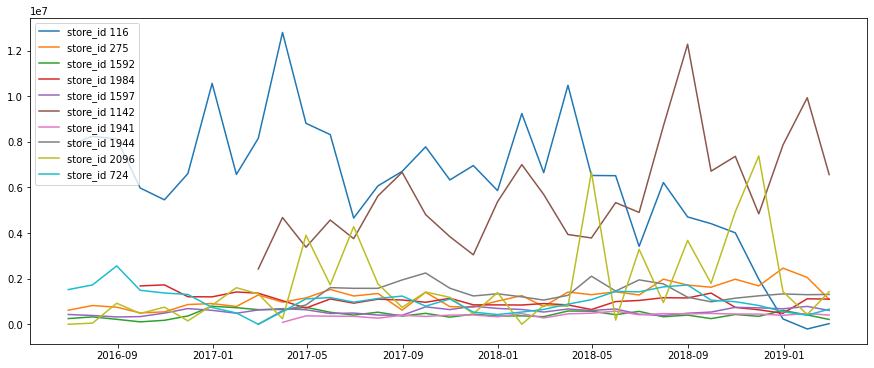

In [94]:
random.seed(1208)

plt.figure(figsize=(15, 6))

for i in make_random(10):

    plt.plot(month_df[month_df.store_id == i].index,
             month_df[month_df.store_id == i].amount,
             label='store_id {}'.format(i))
    
plt.legend()

# Store ID 1142의 데이터를 가지고 시계열 분석

## Store ID 1142 데이터 추출하기

In [95]:
data_1142 = month_df[month_df.store_id==1142]

In [96]:
data_1142_amount = data_1142[['amount']]

data_1142_etc = data_1142[['real_tot_day', 'real_business_day',
                           'num_of_pay', 'num_of_revisit',
                           'installment_term']]

In [97]:
min_amount = int(data_1142_amount['amount'].min())
max_amount = int(data_1142_amount['amount'].max())

print('amount 최소값 : {}'.format(min_amount))
print('amount 최대값 : {}'.format(max_amount))

amount 최소값 : 2424571
amount 최대값 : 12276285


(1424571.0, 13276285.0)

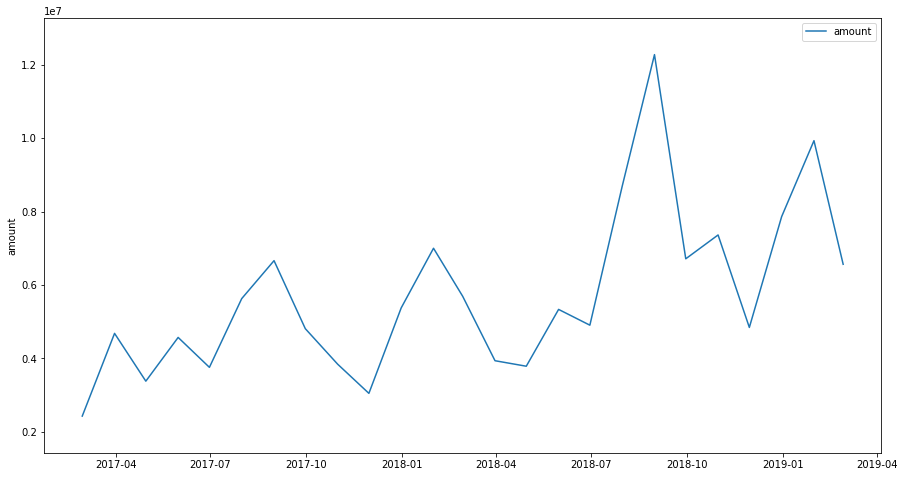

In [98]:
fig = plt.figure(figsize=(15, 8))
amount_fig = sns.lineplot(data=data_1142_amount, x=data_1142_amount.index, y='amount', label='amount')
plt.ylim(min_amount-1000000, max_amount+1000000)

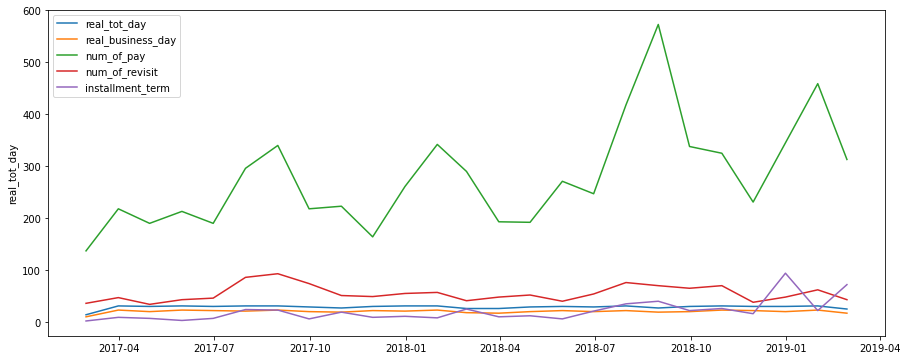

In [99]:
fig = plt.figure(figsize=(15, 6))

ax = fig.add_subplot(1,1,1)

for col in data_1142_etc.columns:

  sns.lineplot(data=data_1142_etc, x=data_1142_etc.index, y=col, label=col)

## Store ID 1142 'Amount' 정상성 확인하기

### 시계열 그래프를 통해 패턴 (평균회귀 및 변동폭 등) 파악

#### 원본 데이터

추세성이 있는 것으로 보임 (주관적)

In [100]:
data_1142_amount['Mean'] = data_1142_amount['amount'].mean()

(1424571.0, 13276285.0)

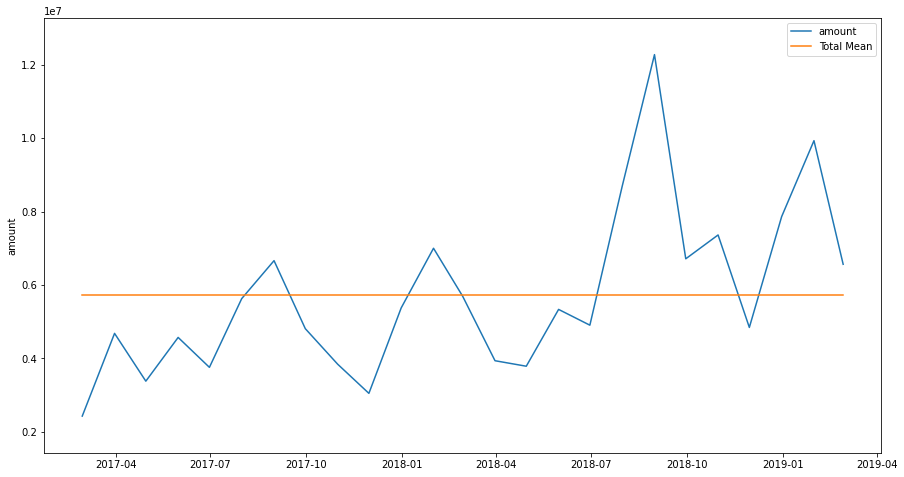

In [101]:
fig = plt.figure(figsize=(15, 8))
sns.lineplot(data=data_1142_amount, x=data_1142_amount.index, y='amount', label='amount')
sns.lineplot(data=data_1142_amount, x=data_1142_amount.index, y='Mean', label='Total Mean')
plt.ylim(min_amount-1000000, max_amount+1000000)

#### 1차 차분 데이터

추세성이 없어진 것으로 보임 (주관적)

In [102]:
difference = list(data_1142_amount['amount'])[:1] + np.diff(list(data_1142_amount['amount'])).tolist()

In [103]:
data_1142_amount['Difference'] = difference
data_1142_amount['Difference Mean'] = data_1142_amount['Difference'].mean()

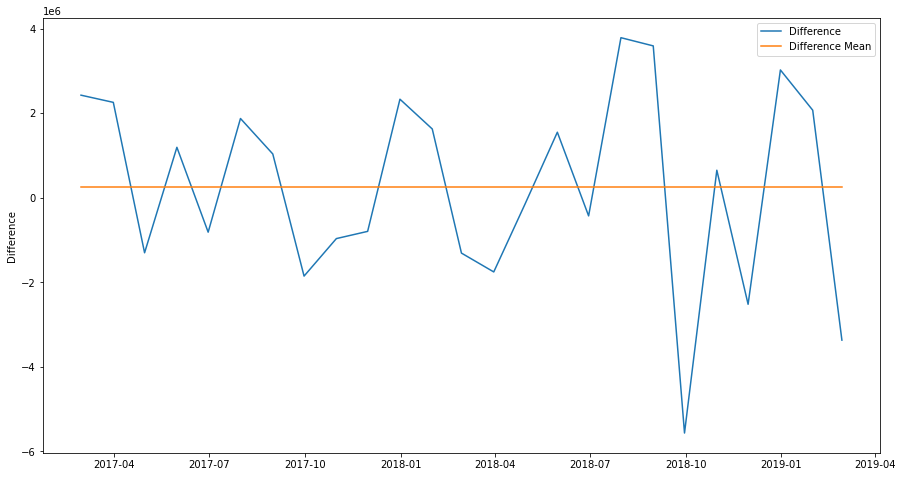

In [104]:
fig = plt.figure(figsize=(15, 8))
sns.lineplot(data=data_1142_amount, x=data_1142_amount.index, y='Difference', label='Difference')
sns.lineplot(data=data_1142_amount, x=data_1142_amount.index, y='Difference Mean', label='Difference Mean')

### 시계열 분해

* Observed : 원본
* Trend : 추세 요인
* Seasonality : 계절 요인
* Cycle / Resdiual : 순환 요인 / 불규칙

#### 원본 데이터

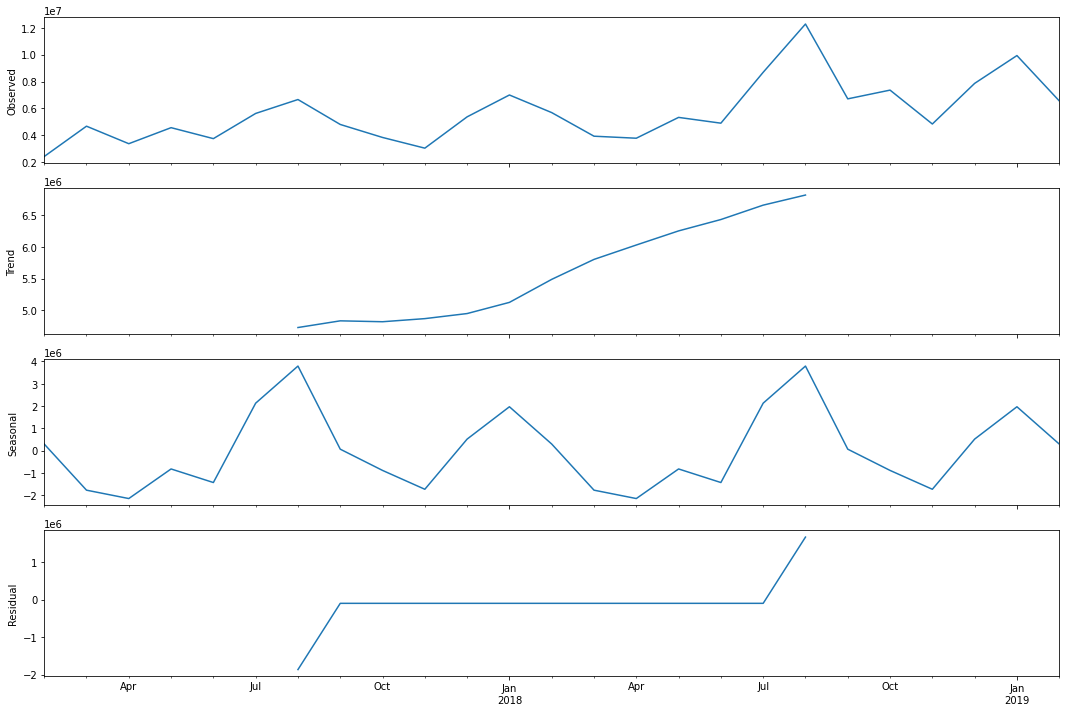

In [105]:
rcParams['figure.figsize']=15,10

model_series = tsa.seasonal_decompose(data_1142_amount['amount'], model='additive')

# 모델 시각화
fig = model_series.plot()

#### 1차 차분 데이터

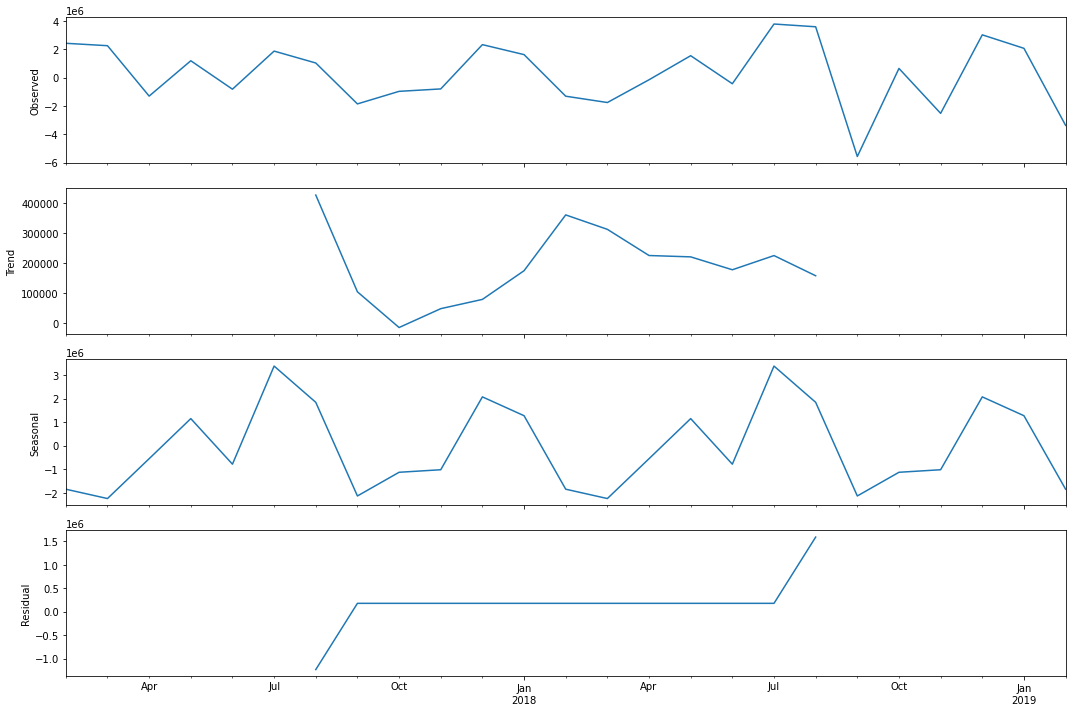

In [106]:
rcParams['figure.figsize']=15,10

model_series = tsa.seasonal_decompose(data_1142_amount['Difference'], model='additive')

# 모델 시각화
fig = model_series.plot()

### ACF & PACF 그래프 확인

원본 데이터는 정상성 데이터인 것으로 판별

#### 원본 데이터

Text(0.5, 1.0, 'PACF')

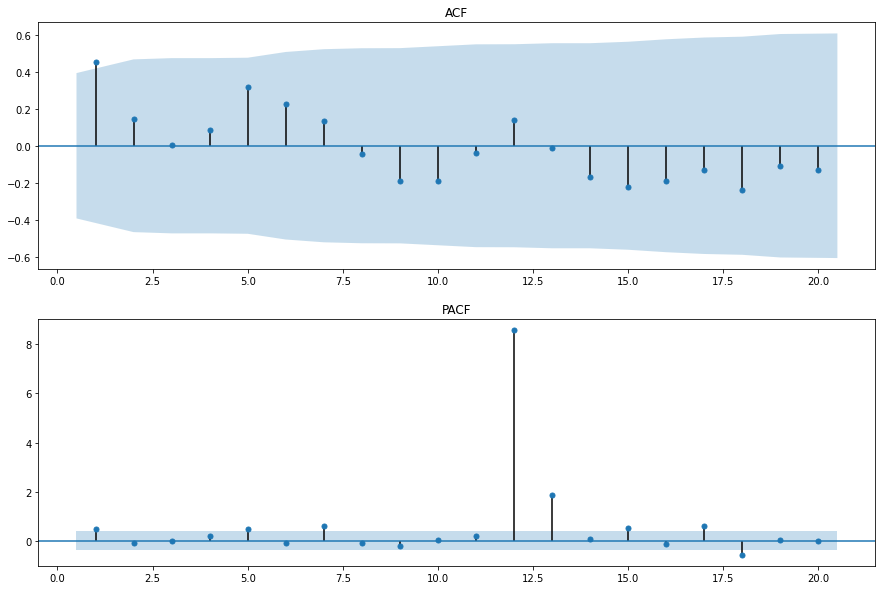

In [107]:
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

sgt.plot_acf(data_1142_amount['amount'], lags = 20, zero = False, ax=ax1)
ax1.set_title("ACF")

sgt.plot_pacf(data_1142_amount['amount'], lags = 20, zero = False, method = ('ols'), ax=ax2)
ax2.set_title("PACF")

#### 1차 차분 데이터

Text(0.5, 1.0, 'PACF')

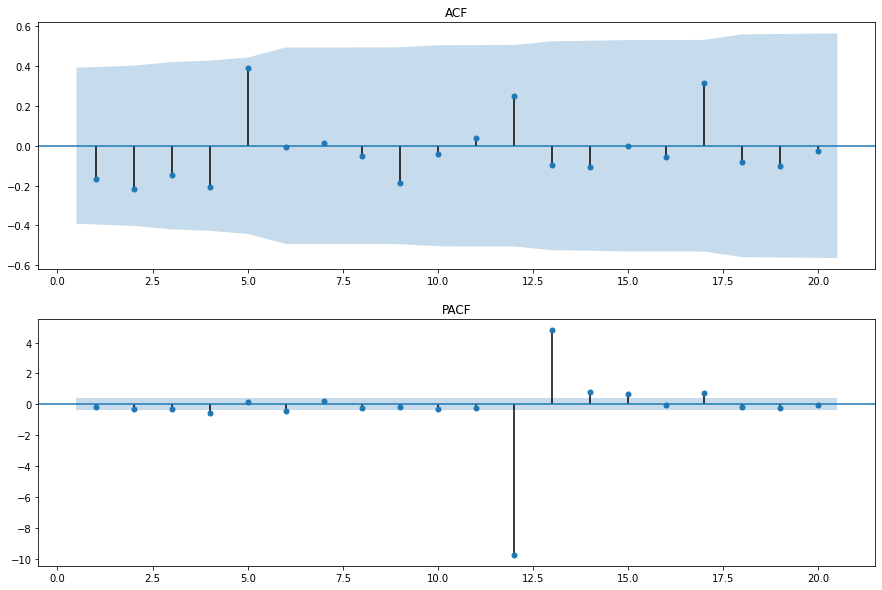

In [108]:
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

sgt.plot_acf(data_1142_amount['Difference'], lags = 20, zero = False, ax=ax1)
ax1.set_title("ACF")

sgt.plot_pacf(data_1142_amount['Difference'], lags = 20, zero = False, method = ('ols'), ax=ax2)
ax2.set_title("PACF")

### 단위근 검정

* p-value > 0.05 : 귀무가설을 채택 -> 비정상성
* p-value < 0.05 : 대립가설을 채택 -> 정상성

In [109]:
def ADF(data):
 
    result = adfuller(data, autolag="AIC")
 
    print("---- Adfuller ----")
    print()
    print('ADF Statistic: %f' % result[0])
    print()
    print('p-value: %1.10f' % result[1])
    print()
    print('Lag: %d' % result[2])
    print()
    print('observation: %d' % result[3])
    print()
    print('Critical Values:')
    print()
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

#### 원본 데이터

In [110]:
ADF(data_1142_amount['amount'])

---- Adfuller ----

ADF Statistic: -3.030226

p-value: 0.0321665153

Lag: 0

observation: 24

Critical Values:

	1%: -3.738
	5%: -2.992
	10%: -2.636


#### 1차 차분 데이터

In [111]:
ADF(data_1142_amount['Difference'])

---- Adfuller ----

ADF Statistic: -2.942687

p-value: 0.0406045114

Lag: 5

observation: 19

Critical Values:

	1%: -3.833
	5%: -3.031
	10%: -2.656


# 모델링

## 시계열 모델

### Simple Moving Average


* 단순이동평균은 특정 기간 동안의 data를 단순 평균하여 계산한다. 따라서 그 기간 동안의 data를 대표하는 값이 이동평균 안에는 그 동안의 data 움직임을 포함하고 있다.
* 이동평균의 특징인 지연(lag)이 발생하며 수학적으로 n/2 시간 만큼의 지연이 발생한다.
* 단순이동평균은 모든 데이터의 중요도를 동일하다고 간주한다.

In [112]:
def make_sma_arr(window_num):

  ma_arr = np.array([])

  for i in month_df.store_id.unique():

    df_set = month_df[month_df.store_id == i]
    ma_arr = np.concatenate((ma_arr,
                             df_set.amount.rolling(window=window_num).mean().values))
    
  return ma_arr

In [113]:
sma_month = month_df.copy()

sma_month.insert(7, 'amount_2ma', make_sma_arr(2))
sma_month.insert(8, 'amount_3ma', make_sma_arr(3))
sma_month.insert(9, 'amount_6ma', make_sma_arr(6))

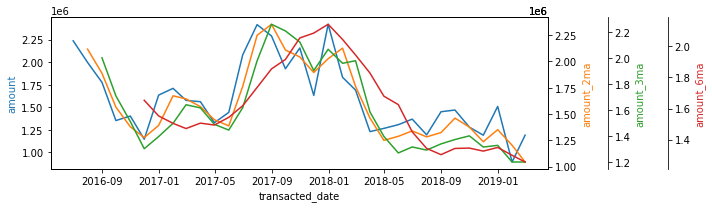

In [114]:
plot_model_graph(sma_month, 1124,
                  'transacted_date',
                  ['amount', 'amount_2ma', 'amount_3ma', 'amount_6ma'])

In [115]:
print("2 winodw SMA MAE Score : ", mae(sma_month.amount_2ma.fillna(0), sma_month.amount.values))
print("3 window SMA MAE Score : ", mae(sma_month.amount_3ma.fillna(0), sma_month.amount.values))
print("6 window SMA MAE Score : ", mae(sma_month.amount_6ma.fillna(0), sma_month.amount.values))

2 winodw SMA MAE Score :  180687.25906004856
3 window SMA MAE Score :  251607.4552831229
6 window SMA MAE Score :  387465.0993765708


### Exponential Moving Average


지수이동평균은 가중이동평균 중의 하나로 단순이동평균보다 최근의 데이터에 높은 가중치를 부여하는 방법

In [116]:
def make_ewm_arr(data_frame, span_num):

    arr_ewm = np.array([])

    for i in data_frame.store_id.unique():

        df_set = data_frame[data_frame.store_id == i]

        # pandas에 내장된 ewm 패키지를 이용하면 지수이동평균을 쉽게 이용할 수 있음
        # 마지막에 .mean()을 해줘야 평균값이 월별로 각각 잘 계산됨
        arr_ewm = np.concatenate((arr_ewm, df_set.amount.ewm(span=span_num).mean().values))
    
    return arr_ewm

In [117]:
ewm_month = month_df.copy()

ewm_month.insert(7, 'amount_3ewm', make_ewm_arr(month_df, 3))
ewm_month.insert(8, 'amount_6ewm', make_ewm_arr(month_df, 6))

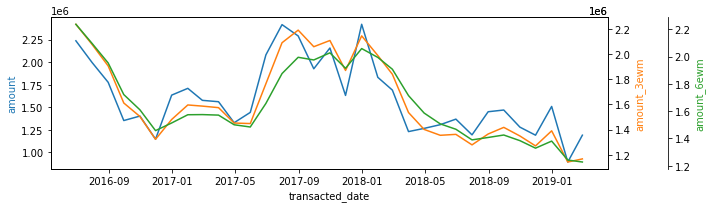

In [118]:
plot_model_graph(ewm_month, 1124, 'transacted_date', ['amount', 'amount_3ewm', 'amount_6ewm'])

### ARMA

In [119]:
size = int(len(data_1142_amount) * 0.7)
train = data_1142_amount[:size]
test = data_1142_amount[size:]

In [120]:
set_arma = sm.tsa.ARMA(train.amount, (2, 2))
set_result = set_arma.fit()

set_output = set_result.forecast(len(test))
set_pred = set_output[0]

Mean value of store_id 1124 : 5721228.571428572
MAE Score of test : 3571068.069237132


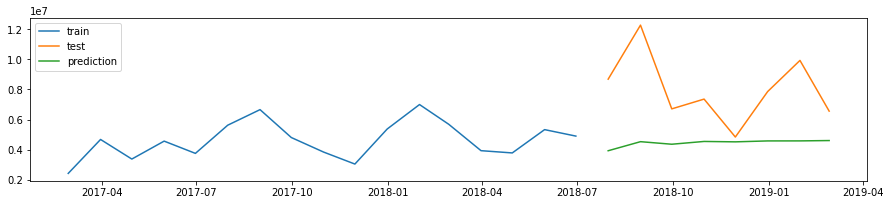

In [121]:
print("Mean value of store_id 1124 :", data_1142_amount.amount.mean())
print("MAE Score of test :", mae(test.amount, set_pred))

plot_train_test_pred_graph(train, test, set_pred)

### ARIMA

In [122]:
p = list(range(0, 6))
d = [0, 1, 2]
q = list(range(0, 6))

pdq = list(itertools.product(p, d, q))

In [123]:
size = int(len(data_1142_amount) * 0.7)
train = data_1142_amount[:size]
test = data_1142_amount[size:]

In [124]:
best_score = 9000000
best_param = 0

for param in tqdm(pdq):

    try:

        arima_model = ARIMA(train.amount.values, order=param)
        result = arima_model.fit()

        if result.aic < best_score:
            best_score = result.aic
            best_param = param

    except:
        continue

  0%|          | 0/108 [00:00<?, ?it/s]

In [125]:
set_arima = ARIMA(data_1142_amount.amount.values, order=best_param)
set_result = set_arima.fit()
set_pred = set_result.forecast(len(test))[0]

Mean value of store_id 1124 : 5721228.571428572
AIC Score of test : 477.51791233570157
Best parameter of (p, d, q):  (0, 2, 1)
MAE Score of test : 9974145.051704463


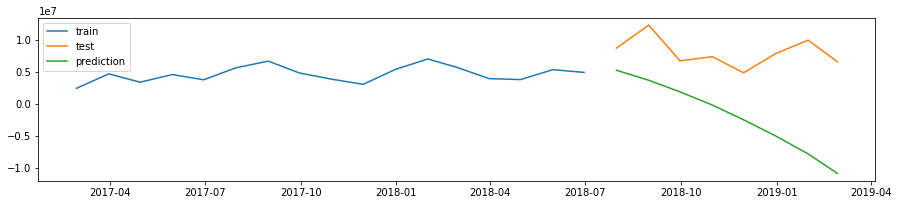

In [126]:
print("Mean value of store_id 1124 :", data_1142_amount.amount.mean())
print("AIC Score of test :", best_score)
print("Best parameter of (p, d, q): ",best_param)
print("MAE Score of test :", mae(test.amount, set_pred))

plot_train_test_pred_graph(train, test, set_pred)

## Exponential Smoothing (지수평활법)

* Simple Exponential Smoothing
* Holt's Exponential Smoothing
* Holt-Winter's Exponential Smoothing

### Simple Exponential Smoothing

* trend나 seasonality 반영을 하지 못함
* level 정도만 수평선으로 나옴

In [127]:
df_set = month_df[month_df.store_id == 1124]

size = int(len(df_set) * 0.7)
train = df_set[:size]
test = df_set[size:]

In [128]:
# 모델 불러오기
ses_model = SimpleExpSmoothing(train.amount)

# 모델 학습
ses_result = ses_model.fit()

# 모델 예측
ses_pred = ses_result.forecast(len(test))

In [129]:
print("store_id 1124 mean value : ", df_set.amount.mean())
print("MAE Score of test :", mae(test.amount, ses_pred))

store_id 1124 mean value :  1605876.1904761903
MAE Score of test : 135783.78195289886


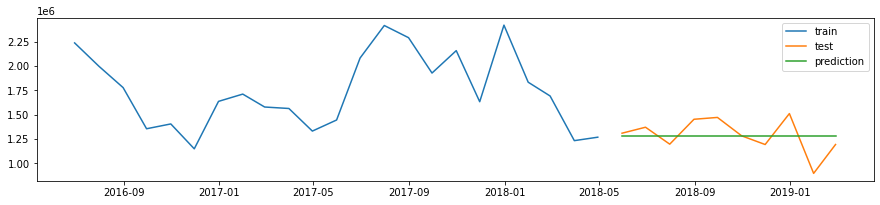

In [130]:
plot_train_test_pred_graph(train, test, ses_pred)

### Holt's Exponential Smoothing

* trend로 데이터를 예측하기 위해 Simple Exponential Smoothing에서 확장한 것이다.
* 예측을 위한 식 외에 level smoothing을 위한 식과 trend smoothing을 위한 식이 포함된다
* 생성된 예측은 선형적으로 나타나기 때문에 예측 범위가 멀어질 수록 over-forecast 되는 경향이 있다.

In [131]:
df_set = month_df[month_df.store_id == 1124]

size = int(len(df_set) * 0.7)
train = df_set[:size]
test = df_set[size:]

holt_model = Holt(np.array(train.amount))
holt_result = holt_model.fit()
holt_pred = holt_result.forecast(len(test))

In [132]:
print("Mean value of store_id 1124 : ", df_set.amount.mean())
print("MAE Score of test :", mae(test.amount, holt_pred))

Mean value of store_id 1124 :  1605876.1904761903
MAE Score of test : 135663.6557101411


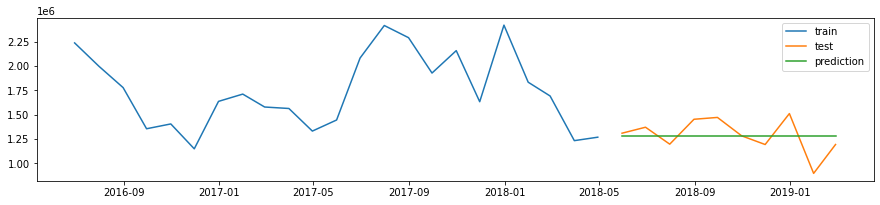

In [133]:
plot_train_test_pred_graph(train, test, holt_pred)

### Holt-Winter's Exponential Smoothing

* Holt-Winter's 방법은 seasonality를 반영하기 위해 Holt's 방법에서 확장된 것이다.
* Holt-Winter's 방법은 예측식과 3개의 smoothing 식으로 구성되어 있다.
  * level에 대한 식  𝑙𝑡 
  * trend에 대한 식  𝑏−𝑡 
  * seasonal에 대한 요소  𝑠𝑡 
  * smoothing parameter에 해당하는  𝛼 ,  𝛽∗ ,  𝛾 
  * seasonality의 빈도를 나타내기 위한  𝑚 
* seasonal이 변화하는 형태에 따라 두 가지 방법이 있다.
  * additive : seasonal의 변화가 일정하게 지속될 때
  * multiplicative : seasonal의 변화가 level에 비례적일 때

In [134]:
df_set = month_df[month_df.store_id == 1124]

size = int(len(df_set) * 0.7)
train = df_set[:size]
test = df_set[size:]

In [135]:
# 최적값을 찾기 위한 기준
es_score = 1000000000
best_period = 0

# 각 store_id 최적의 seasonal period를 찾기 위한 탐색
for p in range(2,(len(train)//2) + 1):

    try:
        # ExponentialSmoothing 패키지에서 trend와 seasonal을 모두 add로 설정하면 추세변동 계절변동을 모두 고려하게 됨
        es_model = ExponentialSmoothing(np.array(train.amount), seasonal_periods=p, trend='add', seasonal='add')
        es_result = es_model.fit()
        es_pred = es_result.forecast(len(test))
        
        # 추정 결과를 검정한 mae값이 기준값(혹은 이전 최적값)보다 작은 경우 이를 계속 업데이트
        if es_score > mae(test.amount, es_pred):
            es_score = mae(test.amount, es_pred)
            best_period = p

    except:
        continue

In [136]:
print("Mean value of store_id 0 :", df_set.amount.mean())
print("MAE Score of test :", es_score)
print("Best seasonal period :", best_period)

Mean value of store_id 0 : 1605876.1904761903
MAE Score of test : 157797.12356943142
Best seasonal period : 2


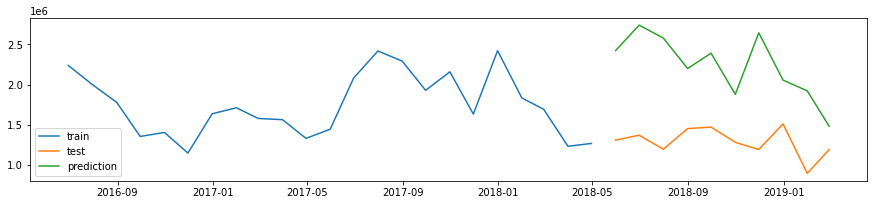

In [137]:
plot_train_test_pred_graph(train, test, es_pred)

## 회귀 모델

### 데이터 전처리

In [138]:
df_month_reg = month_df.copy()

df_month_reg.insert(1, 'year',df_month_reg.index.year)
df_month_reg.insert(2, 'month',df_month_reg.index.month)

df_month_reg.reset_index(drop=True, inplace=True)
df_month_reg = df_month_reg[df_month_reg.store_id==1124]

In [139]:
size = int(len(df_month_reg) * 0.7)
train = df_month_reg[:size]
test = df_month_reg[size:]

### 모델 불러오기

In [140]:
reg_models = [LinearRegression(),
              Ridge(),
              Lasso(),
              ElasticNet(),
              GradientBoostingRegressor(),
              SVR(),
              XGBRegressor()]

reg_model_names = ["LinearRegression",
                    "Ridge",
                    "Lasso",
                    "ElasticNet",
                    "GradientBoositng",
                    "SupportVector",
                    "XGBoost"]

### 테스트

In [141]:
# 각 columns values 예측을 위해 사용할 알고리즘들의 score 확인
def predict_columns(data_frame, x_cols, y_col):

    size = int(len(data_frame) * 0.7)
    train = data_frame[:size]
    test = data_frame[size:]

    Regression_Model = {'Model':reg_model_names,
                        'MAE':[]}

    for i in tqdm(range(len(reg_models))):

        reg = reg_models[i].fit(train[x_cols], train[y_col])
        pred = reg_models[i].predict(test[x_cols])

        print('{}의 MSE : {}'.format(reg_model_names[i], mae(test[y_col], pred.astype(int))))
        plot_train_test_pred_graph(train, test, pred)

        Regression_Model['MAE'].append(mae(test[y_col], pred.astype(int)))

    Regression_Model = pd.DataFrame(Regression_Model).sort_values(by='MAE', ascending=True)

    return Regression_Model

  0%|          | 0/7 [00:00<?, ?it/s]

LinearRegression의 MSE : 228327.1


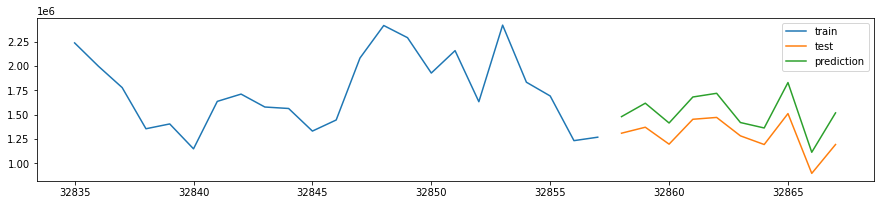

Ridge의 MSE : 172652.6


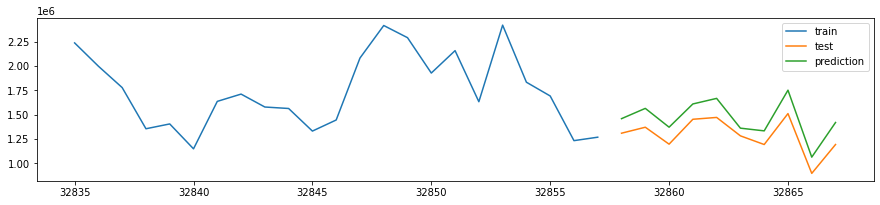

Lasso의 MSE : 228318.7


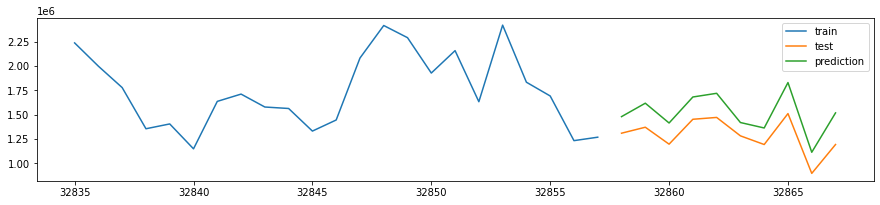

ElasticNet의 MSE : 58219.82857142859


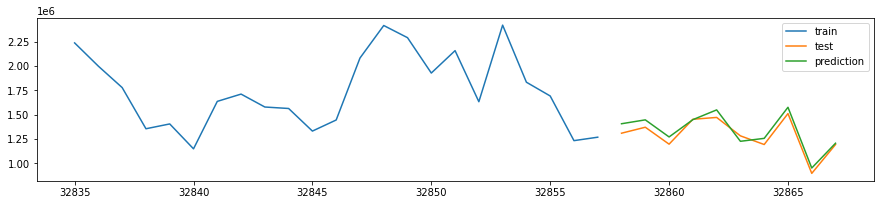

GradientBoositng의 MSE : 89568.91428571427


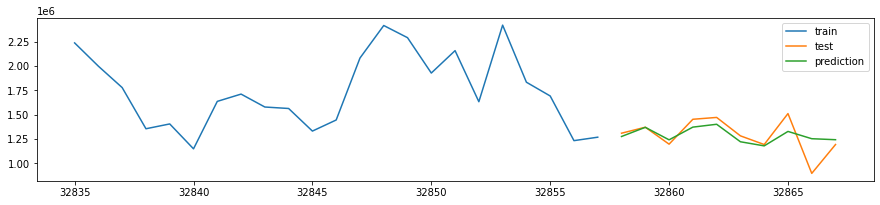

SupportVector의 MSE : 404875.0


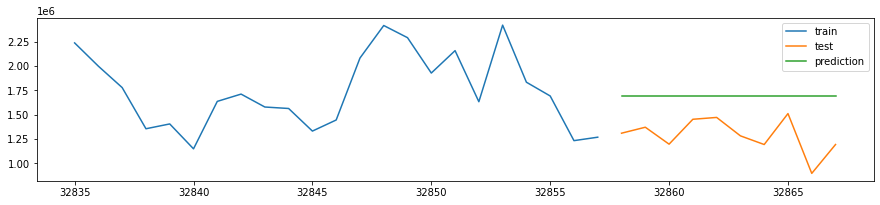

[08:04:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost의 MSE : 78899.47142857146


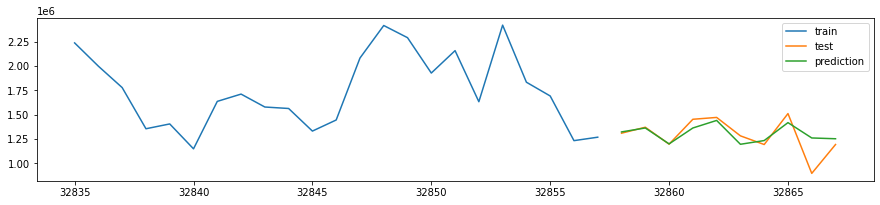

In [142]:
df_Regression_Model = predict_columns(df_month_reg,
                                      ['year', 'month', 'real_tot_day', 'real_business_day',
                                       'num_of_pay', 'num_of_revisit', 'installment_term'],
                                       'amount')

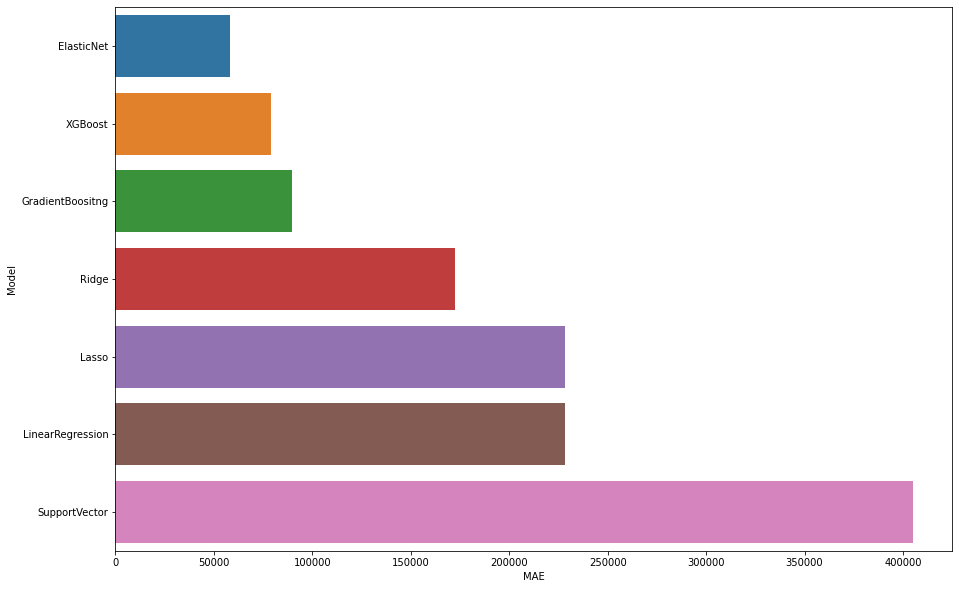

In [143]:
sns.barplot(data=df_Regression_Model, x='MAE', y='Model')

## 딥러닝

### LSTM

#### 데이터 전처리

In [144]:
df_month_dl = month_df.copy()

normalized_arr = np.array([])

for i in tqdm(df_month_dl.store_id.unique()):

    df_set = df_month_dl[df_month_dl.store_id == i].amount.values
    set_arr = np.array([(float(i + 1) / float(df_set[0] + 1))-1 for i in df_set])
    normalized_arr = np.concatenate((normalized_arr, set_arr))

df_month_dl.insert(7, 'normalize', normalized_arr)

  0%|          | 0/1967 [00:00<?, ?it/s]

In [145]:
df_set = df_month_dl[df_month_dl.store_id == 1124]

dl_x = df_set.index.values
dl_y = df_set.normalize

In [146]:
size = int(len(df_set) * 0.7)

x_train = dl_x[:size]
y_train = dl_y[:size]
x_test = dl_x[size:]
y_test = dl_y[size:]

In [147]:
x_train = x_train.reshape(len(x_train), 1)
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))

x_test = x_test.reshape(len(x_test), 1)
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

In [148]:
x_train = x_train.astype(np.float32)
y_train = y_train.astype(np.float32)
x_test = x_test.astype(np.float32)
y_test = y_test.astype(np.float32)

#### 모델 생성하기

In [149]:
model = Sequential()

#Adding the first LSTM layer and some Dropout regularisation

model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))

model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation

model.add(LSTM(units = 50, return_sequences = True))

model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation

model.add(LSTM(units = 50, return_sequences = True))

model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation

model.add(LSTM(units = 50))

model.add(Dropout(0.2))

# Adding the output layer

model.add(Dense(units = 1))


#### 모델 학습하기

In [150]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [151]:
model.fit(x_train, y_train, epochs=100, validation_split=0.05, verbose=0)

#### 모델 예측하기

In [152]:
lstm_pred = model.predict(x_test)

df_lstm_test = pd.DataFrame([((df_set.amount[0] + 1) * (i + 1) - 1) for i in y_test.values], columns=['amount'], index=y_test.index)
df_lstm_pred = pd.DataFrame([((df_set.amount[0] + 1) * (i + 1) - 1)[0] for i in lstm_pred], columns=['amount'])

#### 결과

Mean value of store_id 1124 : 1605876.1904761903
MAE score of test : 507785.7481694311


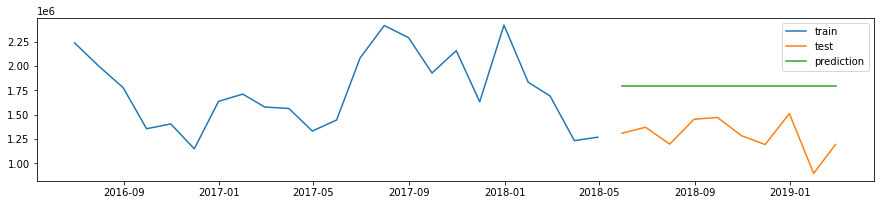

In [153]:
print("Mean value of store_id 1124 :", df_set.amount.mean())
print("MAE score of test :", mae(df_lstm_test, df_lstm_pred))

plot_train_test_pred_graph(df_set[:size], df_lstm_test, df_lstm_pred)